# Image classification

## Setup

Import TensorFlow and other necessary libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 3s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

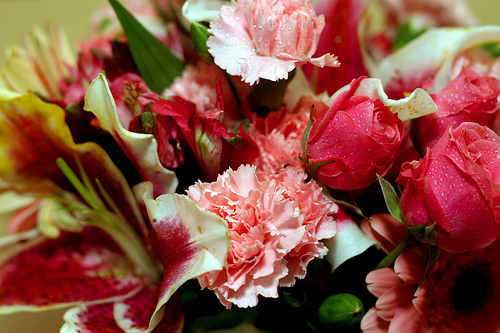

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[5]))

Modify next cell to show some daisy images

In [ ]:
# Create function to plot images

def show_image(image, title='Image', cmap_type='gray'):    
    plt.imshow(image, cmap=cmap_type)        
    plt.title(title)    
    plt.axis('off')    
    plt.show()

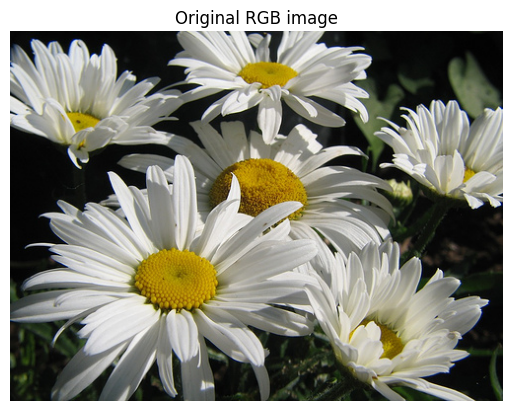

In [ ]:
# Show some daisy images
# Path to daisy images:
daisy = list(data_dir.glob('daisy/*'))


##################################### ADD CODE HERE #################
from PIL import Image
daisy_img = Image.open(str(daisy[np.random.randint(40)]))  # select one image randomly

show_image(daisy_img, 'Original RGB image')

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
PERC_SPLIT = 0.3

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=PERC_SPLIT,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2569 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=PERC_SPLIT,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 1101 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`).

In [ ]:
num_classes = len(class_names)

n_filters_1l = 32

n_filters_2l = 64

n_filters_dense = 128


model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  ### ADD Conv2D layer here, with 32 filters,  kernel_size =3 , padding = same and use relu activation function
  #1 convolution
  layers.Conv2D(n_filters_1l, (3,3), activation='relu',padding='same'), # Input shape is defined in first layer rescaling

  layers.MaxPooling2D(pool_size=(2,2)),
  ### ADD Conv2D layer here, with 64 filters,  kernel_size =3 , padding = same and use relu activation function
  #2 convolution
  layers.Conv2D(n_filters_2l, (3,3), activation='relu',padding='same'),

  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  
  ## ADD Dense Layer here, with 128 filters and relu activation function
  layers.Dense(128, activation='relu'),
  # classifying
  layers.Dense(num_classes)


])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [ ]:
### view model layers here
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129600)            0

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
81/81 [==============================] - 20s 60ms/step - loss: 1.5519 - accuracy: 0.4367 - val_loss: 1.1900 - val_accuracy: 0.5195
Epoch 2/20
81/81 [==============================] - 3s 33ms/step - loss: 0.9556 - accuracy: 0.6427 - val_loss: 1.0552 - val_accuracy: 0.5876
Epoch 3/20
81/81 [==============================] - 3s 33ms/step - loss: 0.6017 - accuracy: 0.7879 - val_loss: 1.0583 - val_accuracy: 0.6022
Epoch 4/20
81/81 [==============================] - 3s 32ms/step - loss: 0.3308 - accuracy: 0.8891 - val_loss: 1.1816 - val_accuracy: 0.6158
Epoch 5/20
81/81 [==============================] - 3s 38ms/step - loss: 0.1235 - accuracy: 0.9669 - val_loss: 1.3829 - val_accuracy: 0.6085
Epoch 6/20
81/81 [==============================] - 3s 33ms/step - loss: 0.0738 - accuracy: 0.9813 - val_loss: 1.8303 - val_accuracy: 0.6094
Epoch 7/20
81/81 [==============================] - 3s 32ms/step - loss: 0.0872 - accuracy: 0.9782 - val_loss: 1.6377 - val_accuracy: 0.5995
Epoch 8/20
8

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

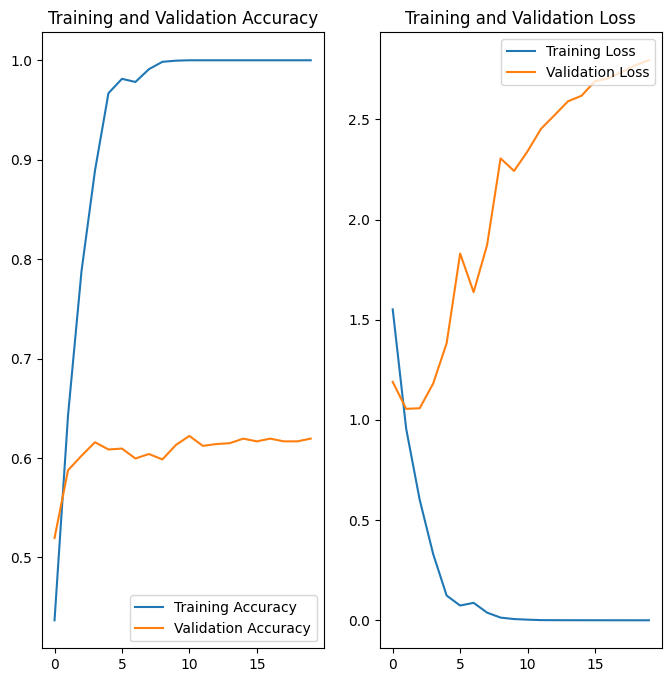

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

In [ ]:
data_augmentation = keras.Sequential([
### ADD CODE HERE for data augmentation ###
layers.RandomFlip("horizontal_and_vertical"), 
layers.RandomContrast(0.25),
layers.RandomRotation(0.2)
], name='data_augmentation') ## name of layer

In [ ]:
model = Sequential([
### ADD CODE HERE ### write the same model layers here as before and include the data_augmentation layer 

layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  ### ADD Conv2D layer here, with 32 filters,  kernel_size =3 , padding = same and use relu activation function
  #1 convolution
data_augmentation,
layers.Conv2D(n_filters_1l, (3,3), activation='relu',padding='same'), # Input shape is defined in first layer rescaling

layers.MaxPooling2D(pool_size=(2,2)),
  ### ADD Conv2D layer here, with 64 filters,  kernel_size =3 , padding = same and use relu activation function
  #2 convolution
layers.Conv2D(n_filters_2l, (3,3), activation='relu',padding='same'),

layers.MaxPooling2D(pool_size=(2,2)),
layers.Flatten(),
  
  ## ADD Dense Layer here, with 128 filters and relu activation function
layers.Dense(128, activation='relu'),
  # classifying
layers.Dense(num_classes)

])


## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
### view model layers here
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 data_augmentation (Sequenti  (None, 180, 180, 3)      0         
 al)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 64)      

In [ ]:
############### ADD CODE HERE #########################

from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping

# modify the learning rate in back propagation

lr_schedule = LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch/10)
)

earlyStop = EarlyStopping(
              patience= 10, # we repeat the operation 10 times
              min_delta=0.02, # difference between worst validation losses 
              baseline=0.8,
              mode='min', # only want the minimum validation loss. If it increases, it will stop the model.
              monitor='val_loss',
              restore_best_weights=True,
              verbose=1)

epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, callbacks=[lr_schedule,earlyStop], verbose = 1)




Epoch 1/20
81/81 [==============================] - 6s 39ms/step - loss: 1.4906 - accuracy: 0.3647 - val_loss: 1.3991 - val_accuracy: 0.3851 - lr: 1.0000e-05
Epoch 2/20
81/81 [==============================] - 3s 36ms/step - loss: 1.3171 - accuracy: 0.4410 - val_loss: 1.2579 - val_accuracy: 0.4532 - lr: 1.2589e-05
Epoch 3/20
81/81 [==============================] - 3s 41ms/step - loss: 1.2079 - accuracy: 0.4827 - val_loss: 1.2253 - val_accuracy: 0.4777 - lr: 1.5849e-05
Epoch 4/20
81/81 [==============================] - 4s 44ms/step - loss: 1.1628 - accuracy: 0.5142 - val_loss: 1.2688 - val_accuracy: 0.4632 - lr: 1.9953e-05
Epoch 5/20
81/81 [==============================] - 4s 45ms/step - loss: 1.1439 - accuracy: 0.5224 - val_loss: 1.1530 - val_accuracy: 0.5204 - lr: 2.5119e-05
Epoch 6/20
81/81 [==============================] - 3s 42ms/step - loss: 1.1099 - accuracy: 0.5469 - val_loss: 1.1620 - val_accuracy: 0.5241 - lr: 3.1623e-05
Epoch 7/20
81/81 [==============================] - 

## Visualize training results


In [ ]:
range(len(history.history['loss']))

range(0, 13)

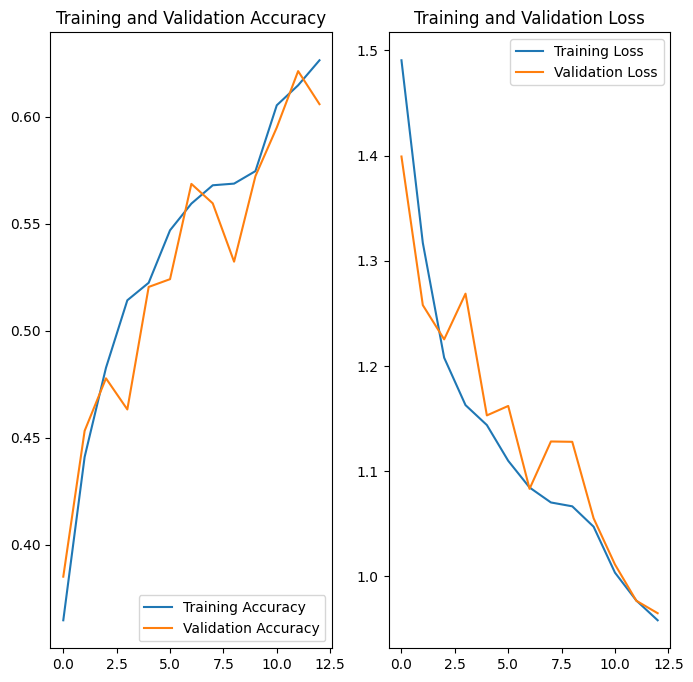

In [ ]:
len_epochs_early_stop  = range(len(history.history['loss']))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs) #We are using a length of epochs used in early stop callback

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(len_epochs_early_stop, acc, label='Training Accuracy')
plt.plot(len_epochs_early_stop, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(len_epochs_early_stop, loss, label='Training Loss')
plt.plot(len_epochs_early_stop, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##  <font color="green"> Report your finidings/observations here: </font>  

---


Did the augmentation increase the model accuracy ? Please explain your observations from the experiments and what did you notice while fitting. 

Please feel free to change the number of epochs and adding new layers if needed. 
PS: It's okay if the model accuracy didn't improve after augmentation[Explain why do you think it happeaned]



# SHORT REPORT:<br>
The data augmentation preprocess was very useful to improve the model overfitting because it was possible to incresse the number of samples in the dataset. The validation accuracy remains constant around 60%, whereas the model did not overfit on training dataset. After using the data augmentation, the training accuracy instead of reaching 100% rapidly, we can see that its accuracy increases with the validation accuracy. This means that we have solved the problem of overfitting. Other actions should be done to increase the validation accuracy, exploring other techniques to develop a better methodology.  <br> In addition, I used the callback to increase the learning rate in each batch, taking care of not diverging and also stopping the model to decrease its accuracy. We have only the best model as we defined in the Early Stopping callback: Having a minimum of 2% of difference in accuracy between different results and repeating this process 10 times.